# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.19 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. State and Action Spaces

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the all agents looks like:', states)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]
The state for the all agents looks like: [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.         -6.65278625 -1.5        -0.          0.
   6.83172083  6.         -0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.         -6.4669857  -1.5         0.          0.
  -6.83172083  6.          0.          0.        ]]


### 3. The RL agent 

The agent implements a standard Deep Deterministic Policy Gradiant [(DDPG)](https://arxiv.org/abs/1509.02971) which is an extension of the widely known DQN algorithm to work with continuous spaces by implementing an actor critic architecture. The details of the implementation can be found in the file ddpg_agent.py.

The agent consist of 2 actors and 2 critics, corresponding to the local and target models in the DDPG algorithm.
All of these have a similar structure of 3 fully connected layers with ReLu activations. There are some details. like dropout or batch normalization that has been optionally added to the model as it can be seen in model.py.

Another important aspect is that the number of hidden units of the critic depends on the number of agents, which could be 1 in the case we want to use the same agent for both player, or 2 if we want to have different actors and critics for each player while keeping centralized learning in the critic.

The basic actor critic agent is implemented in ac_agent.py while the learning algorithm of DDPG is implemented in a derived class in ddpg_agent.py. This approach allows us to easily extend the basic AC agent to other implementations.

In [5]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from workspace_utils import active_session, keep_awake
import numpy as np
from collections import deque

def run_agent(agent, noise=True, n_episodes=1000, random_episodes=1000, max_t=1000, print_every=100):
    np.random.seed(agent.config.seed)
    scores = deque(maxlen=print_every)
    mean_score= []
    for i_episode in keep_awake(range(1, n_episodes+1)):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        score = np.zeros(2)
        for t in range(max_t):
            if i_episode < random_episodes:
                actions = 2*(np.random.rand(2,2)-0.5)
            else:
                actions = agent.act(states, add_noise=noise)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished            
            
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards

            if np.any(dones):
                break 
        scores.append(max(score))
        mean_score.append(max(score))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)), end="")
        agent.save(prefix=agent.alg+'_checkpoint')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)))
        if np.mean(scores) > 0.5:
            print('\rProblem solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)))
            agent.save(prefix=agent.alg+'_model')
            return mean_score
    return mean_score

def plot_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

### 4. Set up agent hyperparameters

The default hyper parameters are set in the following config.  
As it can be seen, the choice for th elayer size is 128, which the possibility to add batch normalization and dropout, although they are disabled by default.

The epsilons and sigma entries refer to the scale, decay rate and deviation of the OU noise.
Alpha and beta correspond to the hyperparameters of prioritized experience replay.

Something worth mention is that the batch size has been heavily incremented to 1024 in order to accumulate interesting transitions during the exploration phase explained in the next section.

In [6]:
from utilities import DictX

def default_config():
    return DictX({'n_agents': 2, 'batch_size': 128, 'buffer_size': int(1e6), 'learn_every': 1, 'tau': 1e-3, \
            'gamma': 0.99, 'lr_actor': 1e-4, 'lr_critic': 1e-4, 'limit_gradients': True, 'seed': 0, \
            'bn_active': False, 'first_layer_size': 128, 'second_layer_size': 128, 'dropout_rate': 0.0, \
            'epsilon_start': 0.2, 'epsilon_decay': 0.999, 'epsilon_min': 0.001, 'sigma': 0.5, \
            'path': 'trained_models/', 'alpha': 0.6,'beta': 0.4,'beta_step': 0.002})

### 5. Train the agent and visualize reward

One key issue that it was observed during training is that the agent was not exploring properly the space with the randomly initialized actor. That was leading to the agent never hitting the ball, and therefore, not learning at all. In order to address that during the first episodes we perform random actions instead of following the actor, as we can see in the function run_agent. The reason of this is to pretrain the model with highly explorative data in order to ensure a good training.

Episode 100	Average Score: 0.03
Episode 200	Average Score: 0.01
Episode 300	Average Score: 0.02
Episode 400	Average Score: 0.03
Episode 500	Average Score: 0.02
Episode 600	Average Score: 0.03
Episode 700	Average Score: 0.06
Episode 800	Average Score: 0.09
Episode 900	Average Score: 0.10
Episode 1000	Average Score: 0.12
Episode 1100	Average Score: 0.19
Problem solved in 1143 episodes!	Average Score: 0.52


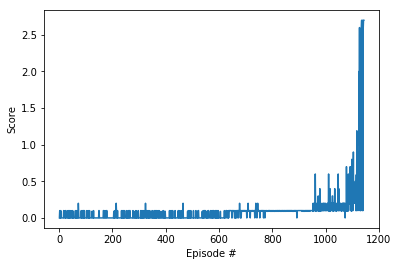

In [11]:
from ddpg_agent import DDPG
            
config = default_config()
config.batch_size = 1024
config.bn_active = True
ddpg = DDPG(state_size, action_size, config)
scores = run_agent(ddpg, n_episodes=5000, random_episodes = 500)
plot_scores(scores)

### 6. Other approaches

We also tried to implement prioritized experience replay with DDPG (PER DDPG) and MADDPG. The details of the implementation can be found in per_ddpg_agent.py and maddpg_agent.py.

#### PER DDPG

As we can see the introduction of the experience replay improves the average score right after the exploration phase, however this dos not speed up the training at the end (the environment is solved in the smae number of episodes!).    
Most likely we could find a set of parameters that better exploits this early advantage of PER, but due to the significant increase of runtime, and the success of vanilla DDPG, the previous method seems preferable.

Setting up Prioritized Experience Replay...
Episode 100	Average Score: 0.01
Episode 200	Average Score: 0.02
Episode 300	Average Score: 0.02
Episode 400	Average Score: 0.01
Episode 500	Average Score: 0.02
Episode 600	Average Score: 0.05
Episode 700	Average Score: 0.06
Episode 800	Average Score: 0.08
Episode 900	Average Score: 0.14
Episode 1000	Average Score: 0.14
Episode 1100	Average Score: 0.27
Problem solved in 1143 episodes!	Average Score: 0.50


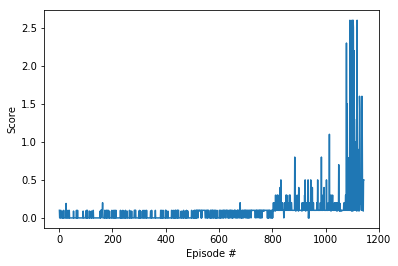

In [7]:
from per_ddpg_agent import PDDPG
            
config = default_config()
config.batch_size = 1024
config.bn_active = True
pddpg = PDDPG(state_size, action_size, config)
scores = run_agent(pddpg, n_episodes=5000, random_episodes = 500)
plot_scores(scores)

#### MADPPG

In this case we solved the problem much later than with DDPG. One potential reason is that the number of randome episodes should have been increased due to the fact that now we have to train 2 agents instead of 1.
Therefore a more refined choice of hyperparameter could bring us closer to the results observed in DDPG

Episode 100	Average Score: 0.02
Episode 200	Average Score: 0.02
Episode 300	Average Score: 0.02
Episode 400	Average Score: 0.03
Episode 500	Average Score: 0.02
Episode 600	Average Score: 0.00
Episode 700	Average Score: 0.00
Episode 800	Average Score: 0.00
Episode 900	Average Score: 0.01
Episode 1000	Average Score: 0.01
Episode 1100	Average Score: 0.08
Episode 1200	Average Score: 0.06
Episode 1300	Average Score: 0.05
Episode 1400	Average Score: 0.04
Episode 1500	Average Score: 0.07
Episode 1600	Average Score: 0.05
Episode 1700	Average Score: 0.07
Episode 1800	Average Score: 0.05
Episode 1900	Average Score: 0.04
Episode 2000	Average Score: 0.09
Episode 2100	Average Score: 0.09
Episode 2200	Average Score: 0.08
Episode 2300	Average Score: 0.08
Episode 2400	Average Score: 0.07
Episode 2500	Average Score: 0.08
Episode 2600	Average Score: 0.08
Episode 2700	Average Score: 0.08
Episode 2800	Average Score: 0.08
Episode 2900	Average Score: 0.09
Episode 3000	Average Score: 0.08
Episode 3100	Averag

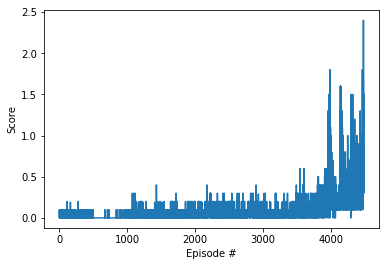

In [10]:
from maddpg_agent import MADDPG

config = default_config()
config.batch_size = 1024
maddpg = MADDPG(state_size, action_size, config)
scores = run_agent(maddpg, n_episodes=5000, random_episodes = 500)
plot_scores(scores)

### 7. Future Work
As a future work it could be interesting to try a natural extension of DDPG which would be the Twin Delayed DDPG (TD3).    

Another possibility would be to try to refine a better hyperparameter set by changing the size of the model, observing the effect of dropout in learning or try different model architectures.